## DAND - Data Wrangling Project - Jupypter Notebook

**This Jupyter Notebook will provide the Python code used to complete the Data Wrangling Project for UDacity's DAND program.**

In this project, our goal is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

To do this, we used The WeRateDogs Twitter archive which contains basic tweet data for all 5000+ of their tweets. However, not all the necessary information is included - for instance retweet count and favorite count are two of the notable column omissions. Hence, we will have to query Twitter's API to gather this valuable data.

In [253]:
# import necessary libraries for this project
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import io
from functools import reduce
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import re

### Gathering Data for this Project

#### 1. Supplied Twitter Archive

In [255]:
df_twitter_csv = pd.read_csv('twitter-archive-enhanced.csv') #import the supplied Twitter Archive
df_twitter = df_twitter_csv.copy() #make a copy of the original csv file prior to data wrangling

Let's first perform a visual assesment.

In [256]:
df_twitter.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [257]:
df_twitter.shape #shape of df

(2356, 17)

#### 2. Dog Image Predictor File

UDacity kindly supplied an Image Predictor file providing the results from running every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs.

The results is a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [258]:
# Downloading the CSV file with the image predictions
pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
urlData = requests.get(pred_url).content

In [259]:
df_csv_pred = pd.read_csv(io.StringIO(urlData.decode('utf-8')), sep='\t') #storing pulled CSV into a df
df_csv_pred.to_csv('image_predictions.tsv', sep='\t', encoding='utf-8') #save dataframe to CSV file
df_pred = df_csv_pred.copy() #make a copy of the original csv file prior to data wrangling

Let's first perform a visual assesment.

In [260]:
df_pred.head() #initial look at the resulting dog prediction df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 4. Twitter API

Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line.

In [9]:
file = open('tweet_json.txt','w') #open saved JSON file
for i in range(df_twitter.shape[0]): #for loop through df_twitter df
    try:
        print(df_twitter.tweet_id[i])
        tweet = api.get_status(df_twitter.tweet_id[i]) #get tweet for that Tweet ID
        with open('tweet_json.txt', 'a') as outfile:  
            json.dump(tweet._json, outfile, 
                      #sort_keys = True, indent = 4, 
                      ensure_ascii = False) #save tweet in a txt file
            outfile.write('\n') #add a new line
    except Exception as e: # catch *all* exceptions
        print(str(df_twitter.tweet_id[i]) + " is not available: " + str(e))
file.close() #close file

892420643555336193
892177421306343426
891815181378084864
891689557279858688
891327558926688256
891087950875897856
890971913173991426
890729181411237888
890609185150312448
890240255349198849
890006608113172480
889880896479866881
889665388333682689
889638837579907072
889531135344209921
889278841981685760
888917238123831296
888804989199671297
888554962724278272
888202515573088257
888202515573088257 is not available: [{'code': 144, 'message': 'No status found with that ID.'}]
888078434458587136
887705289381826560
887517139158093824
887473957103951883
887343217045368832
887101392804085760
886983233522544640
886736880519319552
886680336477933568
886366144734445568
886267009285017600
886258384151887873
886054160059072513
885984800019947520
885528943205470208
885518971528720385
885311592912609280
885167619883638784
884925521741709313
884876753390489601
884562892145688576
884441805382717440
884247878851493888
884162670584377345
883838122936631299
883482846933004288
883360690899218434
8831178360

826204788643753985
826115272272650244
825876512159186944
825829644528148480
825535076884762624
825147591692263424
825120256414846976
825026590719483904
824796380199809024
824775126675836928
824663926340194305
824325613288833024
824297048279236611
824025158776213504
823939628516474880
823719002937630720
823699002998870016
823581115634085888
823333489516937216
823322678127919110
823269594223824897
822975315408461824
822872901745569793
822859134160621569
822647212903690241
822610361945911296
822489057087389700
822462944365645825
822244816520155136
822163064745328640
821886076407029760
821813639212650496
821765923262631936
821522889702862852
821421320206483457
821407182352777218
821153421864615936
821149554670182400
821107785811234820
821044531881721856
820837357901512704
820749716845686786
820690176645140481
820494788566847489
820446719150292993
820314633777061888
820078625395449857
820013781606658049
819952236453363712
819924195358416896
819711362133872643
819588359383371776
819347104292

771136648247640064
771102124360998913
771014301343748096
771004394259247104
770787852854652928
770772759874076672
770743923962707968
770655142660169732
770414278348247044
770293558247038976
770093767776997377
770069151037685760
769940425801170949
769695466921623552
769335591808995329
769212283578875904
768970937022709760
768909767477751808
768855141948723200
768609597686943744
768596291618299904
768554158521745409
768473857036525572
768193404517830656
767884188863397888
767754930266464257
767500508068192258
767191397493538821
767122157629476866
766864461642756096
766793450729734144
766714921925144576
766693177336135680
766423258543644672
766313316352462849
766078092750233600
766069199026450432
766008592277377025
765719909049503744
765669560888528897
765395769549590528
765371061932261376
765222098633691136
764857477905154048
764259802650378240
763956972077010945
763837565564780549
763183847194451968
763167063695355904
763103485927849985
762699858130116608
762471784394268675
762464539388

711743778164514816
711732680602345472
711694788429553666
711652651650457602
711363825979756544
711306686208872448
711008018775851008
710997087345876993
710844581445812225
710833117892898816
710658690886586372
710609963652087808
710588934686908417
710296729921429505
710283270106132480
710272297844797440
710269109699739648
710153181850935296
710140971284037632
710117014656950272
709918798883774466
709901256215666688
709852847387627521
709566166965075968
709556954897764353
709519240576036864
709449600415961088
709409458133323776
709225125749587968
709207347839836162
709198395643068416
709179584944730112
709158332880297985
709042156699303936
708853462201716736
708845821941387268
708834316713893888
708810915978854401
708738143638450176
708711088997666817
708479650088034305
708469915515297792
708400866336894977
708356463048204288
708349470027751425
708149363256774660
708130923141795840
708119489313951744
708109389455101952
708026248782585858
707995814724026368
707983188426153984
707969809498

682088079302213632
682059653698686977
682047327939461121
682032003584274432
682003177596559360
681981167097122816
681891461017812993
681694085539872773
681679526984871937
681654059175129088
681610798867845120
681579835668455424
681523177663676416
681340665377193984
681339448655802368
681320187870711809
681302363064414209
681297372102656000
681281657291280384
681261549936340994
681242418453299201
681231109724700672
681193455364796417
680970795137544192
680959110691590145
680940246314430465
680934982542561280
680913438424612864
680889648562991104
680836378243002368
680805554198020098
680801747103793152
680798457301471234
680609293079592961
680583894916304897
680497766108381184
680494726643068929
680473011644985345
680440374763077632
680221482581123072
680206703334408192
680191257256136705
680176173301628928
680161097740095489
680145970311643136
680130881361686529
680115823365742593
680100725817409536
680085611152338944
680070545539371008
680055455951884288
679877062409191424
679872969355

670452855871037440
670449342516494336
670444955656130560
670442337873600512
670435821946826752
670434127938719744
670433248821026816
670428280563085312
670427002554466305
670421925039075328
670420569653809152
670417414769758208
670411370698022913
670408998013820928
670403879788544000
670385711116361728
670374371102445568
670361874861563904
670338931251150849
670319130621435904
670303360680108032
670290420111441920
670093938074779648
670086499208155136
670079681849372674
670073503555706880
670069087419133954
670061506722140161
670055038660800512
670046952931721218
670040295598354432
670037189829525505
670003130994700288
669993076832759809
669972011175813120
669970042633789440
669942763794931712
669926384437997569
669923323644657664
669753178989142016
669749430875258880
669684865554620416
669683899023405056
669682095984410625
669680153564442624
669661792646373376
669625907762618368
669603084620980224
669597912108789760
669583744538451968
669573570759163904
669571471778410496
669567591774

** Read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. **

In [261]:
dict_json = [] #new str
i = 0 #initialise i
f = open('tweet_json.txt','r') #open json/txt file
for line in f.readlines(): #read each line of txt file and appent to str
    dict_json.append(line)
    i+=1

In [262]:
df_json_new = {'id': [], 'retweet_count': [], 'favorite_count': []} #dict with desired cols
df_twitter_json = pd.DataFrame(data = df_json_new) #empty dataframe from dict
for i in range(0,len(dict_json)): #loop through dict
    python_dict = json.loads(dict_json[i]) #convert str line to dict using json.loads
    df_json_dict = pd.DataFrame.from_dict(python_dict,orient='index') #convert dict to df
    df_json_tr = pd.DataFrame.transpose(df_json_dict) #transpose col and rows
    df_json_red = df_json_tr[['id','retweet_count','favorite_count']] #extract desired cols
    df_twitter_json = pd.concat([df_twitter_json, df_json_red], ignore_index=True) #join existing df with newly created df
    df_twitter_json = df_twitter_json[['id','retweet_count','favorite_count']] #order cols as desired

In [263]:
df_json = df_twitter_json.copy() #make a copy of the original csv file prior to data wrangling

Let's perform a visual assesment of the resulting dataframe.

In [264]:
df_json.head() #show first 5 lines of resulting df for verification purposes

,id,retweet_count,favorite_count
0,892420643555336193,8696,39108
1,892177421306343426,6383,33498
2,891815181378084864,4241,25240
3,891689557279858688,8796,42472
4,891327558926688256,9576,40631


In [265]:
df_json.shape

(2346, 3)

### Assessing Data for this Project

Key points to remember:
- We only want original ratings (no retweets) that have images
- The requirements of this project are only to assess and clean at least **eight (8) quality issues and two (2) tidiness issues**
- We do not need to gather the tweets beyond August 1st, 2017

#### Assess
Our gathering step resulted in three dataframes: df_twitter, df_pred, and df_json. Let's have initial look at each.

##### df_twitter

In [266]:
df_twitter.shape

(2356, 17)

In [267]:
df_twitter.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

** We note that some IDs are int64 while other are float64 type. All IDs should be strings, not ints or floats, because we are not going to perform mathematical operations over them - they are labels or identifiers.**

In [268]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [269]:
print("There are {} duplicates in df_twitter".format(sum(df_twitter.duplicated())))

There are 0 duplicates in df_twitter


##### df_pred

In [270]:
df_pred.shape

(2075, 12)

In [271]:
df_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [272]:
df_pred.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [273]:
print("There are {} duplicates in df_pred".format(sum(df_pred.duplicated())))

There are 0 duplicates in df_pred


** We note that tweet_ID is also int64 type in df_pred. All IDs should be strings.**

##### df_json

In [274]:
df_json.shape

(2346, 3)

In [275]:
df_json.head()

,id,retweet_count,favorite_count
0,892420643555336193,8696,39108
1,892177421306343426,6383,33498
2,891815181378084864,4241,25240
3,891689557279858688,8796,42472
4,891327558926688256,9576,40631


In [276]:
df_json.dtypes

id                object
retweet_count     object
favorite_count    object
dtype: object

### Define - Cleaning (To-Do List)

1. convert tweet_id from int64 to a string (in df_twitter)
2. convert in_reply_to_status_id from float to string (in df_twitter)
3. convert in_reply_to_user_id from float to string (in df_twitter)
4. convert retweeted_status_id from float to string (in df_twitter)
5. convert retweeted_status_user_id from float to string (in df_twitter)
6. convert timestamp from str to datetime type (in df_twitter)
7. remove retweeted tweets by using retweeted_status_timestamp col (in df_twitter)
8. convert retweet_count from str to int64 (in df_json)
9. convert favorite_count from str to int64 (in df_json)
10. Rename first colum of j_son as tweet_id for consistency with other two dataframes
11. Make sure decimal marks were rightly extracted from tweets (in df_twitter)

#### Code

**1. convert tweet_id from int64 to a string (in df_twitter)**

In [277]:
df_twitter.tweet_id = df_twitter.tweet_id.astype(str)

**2. convert in_reply_to_status_id from float to string (in df_twitter)**

In [278]:
df_twitter.in_reply_to_status_id = df_twitter.in_reply_to_status_id.astype(str)

**3. convert in_reply_to_user_id from float to string (in df_twitter)**

In [279]:
df_twitter.in_reply_to_user_id = df_twitter.in_reply_to_user_id.astype(str)

**4. convert retweeted_status_id from float to string (in df_twitter)**

In [280]:
df_twitter.retweeted_status_id = df_twitter.retweeted_status_id.astype(str)

**5. convert retweeted_status_user_id from float to string (in df_twitter)**

In [281]:
df_twitter.retweeted_status_user_id = df_twitter.retweeted_status_user_id.astype(str)

**6. convert timestamp from str to datetime type (in df_twitter)**

In [282]:
df_twitter['timestamp'] = pd.to_datetime(df_twitter['timestamp'])

**7. remove retweeted tweets by using retweeted_status_timestamp col (in df_twitter)**

In [283]:
df_twitter = df_twitter[pd.notnull(df_twitter['retweeted_status_timestamp']) == False]

#### Test

In [284]:
df_twitter.retweeted_status_timestamp.notnull().sum() #check that all retweets removed

0

In [285]:
df_twitter.drop(columns=['retweeted_status_id', #drop the columns related to retweets
                         'retweeted_status_user_id', 
                         'retweeted_status_timestamp'], inplace=True)

In [286]:
df_twitter.reset_index(drop=True, inplace=True) #reset the index

In [287]:
df_twitter.dtypes #check that dataypes in df_twitter

tweet_id                         object
in_reply_to_status_id            object
in_reply_to_user_id              object
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
rating_numerator                  int64
rating_denominator                int64
name                             object
doggo                            object
floofer                          object
pupper                           object
puppo                            object
dtype: object

#### Code

**8. convert retweet_count from str to int64 (in df_json)**

In [288]:
df_json['retweet_count'] = df_json['retweet_count'].astype(int)

**9. convert favorite_count from str to int64 (in df_json)**

In [289]:
df_json['favorite_count'] = df_json['favorite_count'].astype(int)

#### Test

In [290]:
df_json.dtypes #check that all types have indeed been converted

id                object
retweet_count      int64
favorite_count     int64
dtype: object

**10. Rename first colum of j_son as tweet_id for consistency with other two dataframes**

#### Code

In [291]:
df_json = df_json.rename(columns={'id': 'tweet_id'})

#### Test

In [292]:
df_json.dtypes #check that col renamed

tweet_id          object
retweet_count      int64
favorite_count     int64
dtype: object

**11. Make sure decimal marks were rightly extracted from tweets (in df_twitter)**

**Code**

In [293]:
df_twitter.dtypes

tweet_id                         object
in_reply_to_status_id            object
in_reply_to_user_id              object
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
rating_numerator                  int64
rating_denominator                int64
name                             object
doggo                            object
floofer                          object
pupper                           object
puppo                            object
dtype: object

**First we need to change the type of rating_numerator to float.**

In [294]:
df_twitter.rating_numerator = df_twitter.rating_numerator.astype(float)

In [295]:
df_twitter.dtypes #check that conversation was successful

tweet_id                         object
in_reply_to_status_id            object
in_reply_to_user_id              object
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
rating_numerator                float64
rating_denominator                int64
name                             object
doggo                            object
floofer                          object
pupper                           object
puppo                            object
dtype: object

**The code below focuses on rectifying cases where the algorithm picked up only 5/10 when the actual mark was 9.5/10**

In [296]:
df_twitter.shape

(2175, 14)

In [297]:
index_new_mark = 0 #initialise index
index_no_dec = 0 #initialise index

In [298]:
for i in range(df_twitter.shape[0]):
    float_mark = df_twitter.iloc[i].rating_numerator
    float_mark_str = str(float_mark)
    int_mark_str = re.search('(.+?).', float_mark_str).group(1)
    
    #Here we try determine where the actual mark in the tweet is a decimal
    m = re.search('(.+?).%s/10' % int_mark_str, df_twitter.text[i])
    if m:
        search_res = m.group(1)
        #loop through the found text to locate digits to add to actual mark
        actual_mark = "" #initialise actual_mark string
        for n in range(1,len(search_res)): #let's pick up all digits prior to decimal point
            if (str.isdigit(search_res[-n])):
                actual_mark += str(search_res[-n]) #if it's a digit, store it in actual_mark
            else:
                break
        actual_mark = actual_mark[::-1] #reverse order of string 
        actual_mark = "." + int_mark_str #add rest of the mark
        df_twitter.iloc[1,7] = float(actual_mark) #replace with new mark in the df; use iloc to avoid slicing warning message
        index_new_mark += 1
    else:
        index_no_dec += 1

print("Number of marks rectified: " + str(index_new_mark))
print("Number of marks not changed: " + str(index_no_dec))

Number of marks rectified: 848
Number of marks not changed: 1327


### Tidiness

In tidy data:
- Each variable forms a column.
- Each observation forms a row.
- Each type of observational unit forms a table.

The first two conditions are met in our joined dataframe. However, there clearly are more than one observational unit in the joined dataframe. Hence, let's split the dataframe into two sub-tables with the same tweet_id column included. 

### Define Tidiness (To-do List)

1. Organise tables such as that each type of observational unit forms one table
2. Create a new dataframe containing information on the dog in the tweet
2. Aggregate values for dog types in a "dog_stage" column
2. Let'join all three dataframes and store the master df in a CSV
3. Finally, let's join the dataframes and store them in a SQLite database

**1. Organise tables such as that each type of observational unit forms one table**

#### Code

**The first table will hold info on the tweets gathered from all three tables**

In [341]:
df_tw1 = df_twitter[['tweet_id',
                    'in_reply_to_status_id',
                    'in_reply_to_user_id',
                    'timestamp',
                    'source',
                    'text', 
                    'expanded_urls']].copy() 

In [342]:
df_tw2 = df_pred[['tweet_id',
                  'jpg_url', 
                  'img_num']]

In [343]:
df_tw3 = df_json[['tweet_id',
                  'retweet_count', 
                  'favorite_count']]

In [344]:
#this table stores info on the tweets
df_tw_ini = pd.merge(df_tw1, df_tw2, how='outer', on='tweet_id') 
df_tw = pd.merge(df_tw_ini, df_tw3, how='outer', on='tweet_id') 

In [345]:
df_tw.reset_index(drop=True, inplace=True) #reset the index

**Second table will hold info on the dogs in the tweets**

In [346]:
df_dog = df_twitter[['tweet_id',
                     'name',
                     'rating_numerator', 
                     'rating_denominator',
                     'doggo',
                     'floofer',
                     'pupper', 
                     'puppo']].copy() #this table stores info on the dog

**Third table will hold information on the neural network predictions**

In [347]:
df_nn = df_pred[['tweet_id',
                 'p1',
                 'p1_conf','p1_dog', 
                 'p2', 
                 'p2_conf',
                 'p2_dog',
                 'p3', 
                 'p3_conf',
                 'p3_dog']].copy() #this table stores info on the dog

**Test**

In [348]:
df_tw.dtypes

tweet_id                         object
in_reply_to_status_id            object
in_reply_to_user_id              object
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
jpg_url                          object
img_num                         float64
retweet_count                   float64
favorite_count                  float64
dtype: object

In [349]:
df_dog.dtypes

tweet_id               object
name                   object
rating_numerator      float64
rating_denominator      int64
doggo                  object
floofer                object
pupper                 object
puppo                  object
dtype: object

In [350]:
df_nn.dtypes

tweet_id      int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

**2. Aggregate values for dog types in a "dog_stage" column**

In [351]:
df_dog_info = pd.melt(df_dog, id_vars=["tweet_id", 
                                       "name", 
                                       "rating_numerator", 
                                       "rating_denominator"], 
                      var_name="dog_type_est", value_name="dog_type")

In [352]:
df_dog_info = df_dog_info.drop('dog_type_est', axis=1)

In [353]:
df_dog_info = df_dog_info.loc[df_dog_info.dog_type != "None"]
df_dog_info.reset_index(drop=True, inplace=True) #reset the index

#### Test

In [354]:
df_dog_info.head()

,tweet_id,name,rating_numerator,rating_denominator,dog_type
0,890240255349198849,Cassie,14.0,10,doggo
1,884162670584377345,Yogi,12.0,10,doggo
2,872967104147763200,None,12.0,10,doggo
3,871515927908634625,Napolean,12.0,10,doggo
4,871102520638267392,None,14.0,10,doggo


**7. Let's join the dataframe in a master dataframe and save it in a CSV file.**

In [355]:
ini_merge = pd.merge(df_tw, df_dog, how='outer', on='tweet_id')
twitter_archive_master = pd.merge(ini_merge, df_nn, how='outer', on='tweet_id')

In [356]:
print("There are {} duplicates in the master data set".format(sum(twitter_archive_master.tweet_id.duplicated())))

There are 0 duplicates in the master data set


In [357]:
twitter_archive_master.reset_index(drop=True, inplace=True) #reset the index

In [358]:
twitter_archive_master.to_csv('twitter_archive_master.csv', sep='\t', encoding='utf-8') #save dataframe to CSV file

**8. Let's store the cleaned dataframes in a SQLite database**

In [359]:
# Create SQLAlchemy Engine and empty database
engine = create_engine('sqlite:///rate_dogs_project.db')

In [360]:
# Store dataframes tables in rate_dogs_project.db
twitter_archive_master.to_sql('master', engine, index=False)

### Visualizing Data for this Project
- Analyze and visualize your wrangled data.
- At least three (3) insights and one (1) visualization must be produced.

### Insight 1: Dog stages frequency in the data

In [361]:
df_dog_info.head()

,tweet_id,name,rating_numerator,rating_denominator,dog_type
0,890240255349198849,Cassie,14.0,10,doggo
1,884162670584377345,Yogi,12.0,10,doggo
2,872967104147763200,None,12.0,10,doggo
3,871515927908634625,Napolean,12.0,10,doggo
4,871102520638267392,None,14.0,10,doggo


In [362]:
df_dog_info.dog_type.value_counts()

pupper     234
doggo       87
puppo       25
floofer     10
Name: dog_type, dtype: int64

- There are 10 Floofers in our collected Tweets!
- There are 234 Puppers in our collected Tweets!
- There are 10 Puppers in our collected Tweets!
- There are 10 87 Doggos in our collected Tweets!

### Insight 2: Number of unique dog names

In [363]:
df_dog_info.name.value_counts(normalize=True)[:5]

None      0.429775
a         0.011236
Cooper    0.008427
just      0.008427
Maggie    0.005618
Name: name, dtype: float64

- Unfortunately, it seems our algorithm didn't go a great job at picking the names of the dogs from the dataset. We already have enough tasks completed for this project so we'll leave that for another time. Using the current dataframe, we can see that if we ommit 'None' and 'a', the most popular dog names are: Cooper, Pickles, Milo!

### Insight 3: Most favourited dog photo in our data

In [364]:
twitter_archive_master.dtypes

tweet_id                         object
in_reply_to_status_id            object
in_reply_to_user_id              object
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
jpg_url                          object
img_num                         float64
retweet_count                   float64
favorite_count                  float64
name                             object
rating_numerator                float64
rating_denominator              float64
doggo                            object
floofer                          object
pupper                           object
puppo                            object
p1                               object
p1_conf                         float64
p1_dog                           object
p2                               object
p2_conf                         float64
p2_dog                           object
p3                               object


In [366]:
most_fav_dog = twitter_archive_master.loc[twitter_archive_master.favorite_count == twitter_archive_master.favorite_count.max()]
most_fav_dog.favorite_count

3919    144167.0
Name: favorite_count, dtype: float64

In [367]:
most_fav_dog.jpg_url

3919    https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
Name: jpg_url, dtype: object

**The most favourited dog tweet was a Puppo! The photo of the dog (shown below) was tweeted on 2017-01-21 at 18:26:02.**

<img src="https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg",width=400,height=400>

### Visualisation

In [368]:
df_dog_rating.head(1)

,tweet_id,rating_numerator,rating_denominator
0,892420643555336193,13.0,10.0


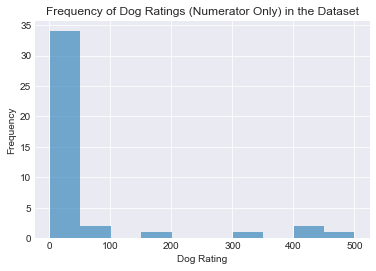

In [369]:
rating_dogs = df_dog_rating.groupby(['rating_numerator']).count()['tweet_id']
red_bars = plt.hist(rating_dogs, alpha=.6)
plt.title('Frequency of Dog Ratings (Numerator Only) in the Dataset')
plt.xlabel('Dog Rating')
plt.ylabel('Frequency');
plt.legend()
plt.savefig('plot1.png')

**Let's add an extra column with the numerator/denominator ration**

In [370]:
df_dog_rating['ratings_dogs_mark'] = df_dog_rating.rating_numerator / df_dog_rating.rating_denominator

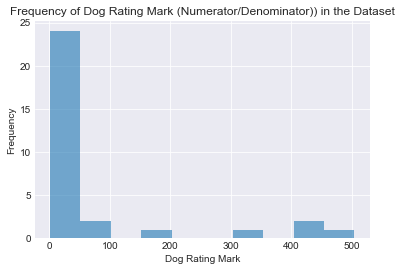

In [371]:
rating_dogs = df_dog_rating.groupby(['ratings_dogs_mark']).count()['tweet_id']
red_bars = plt.hist(rating_dogs, alpha=.6)
plt.title('Frequency of Dog Rating Mark (Numerator/Denominator)) in the Dataset')
plt.xlabel('Dog Rating Mark')
plt.ylabel('Frequency');
plt.legend()
plt.savefig('plot2.png')

**A few dogs there have a really high ratings! A future exercise would be to check if the algorithm that extracted the mark from the tweet may have been off for the outliers in the distribution shown above.**